## Strandard Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Explore Data

In [2]:
df_ks = pd.read_csv('KS_train_data.csv', delimiter= ',')
data_ks_to_predict = pd.read_csv('KS_test_data.csv', delimiter= ';')

df_ks_to_display = pd.read_csv('KS_train_data.csv', delimiter= ',')

### Describe Data

In [9]:
df_ks.describe()

,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,launched_at,pledged,usd_pledged
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,151.089430,1.241108e+04,1.400524e+09,1.406896e+09,1.017654,4.447512e+04,1.403972e+09,1.312485e+04,1.241284e+04
std,1163.024964,1.005545e+05,6.334581e+07,6.340574e+07,0.169773,1.256033e+06,6.360489e+07,1.080345e+05,1.005368e+05
min,0.000000,0.000000e+00,1.240366e+09,1.243556e+09,0.009337,1.000000e-02,1.240674e+09,0.000000e+00,0.000000e+00
25%,4.000000,1.250000e+02,1.349203e+09,1.357171e+09,1.000000,1.500000e+03,1.354313e+09,1.250000e+02,1.250000e+02
50%,28.000000,1.650000e+03,1.408426e+09,1.415244e+09,1.000000,5.000000e+03,1.412373e+09,1.635500e+03,1.651000e+03
75%,86.000000,6.271250e+03,1.447206e+09,1.454243e+09,1.000000,1.200000e+04,1.451252e+09,6.310000e+03,6.275042e+03
max,105857.000000,1.026684e+07,1.517539e+09,1.518702e+09,1.401112,1.000000e+08,1.518037e+09,1.026685e+07,1.026685e+07


### Data Display


**[goal] => USD_goal**

In [10]:
df_ks_to_display['usd_goal'] = df_ks_to_display['goal'] *df_ks_to_display['fx_rate']
df_ks_to_display.describe()

,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,launched_at,pledged,usd_pledged,usd_goal
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,151.089430,1.241108e+04,1.400524e+09,1.406896e+09,1.017654,4.447512e+04,1.403972e+09,1.312485e+04,1.241284e+04,4.052436e+04
std,1163.024964,1.005545e+05,6.334581e+07,6.340574e+07,0.169773,1.256033e+06,6.360489e+07,1.080345e+05,1.005368e+05,1.191352e+06
min,0.000000,0.000000e+00,1.240366e+09,1.243556e+09,0.009337,1.000000e-02,1.240674e+09,0.000000e+00,0.000000e+00,1.000000e-02
25%,4.000000,1.250000e+02,1.349203e+09,1.357171e+09,1.000000,1.500000e+03,1.354313e+09,1.250000e+02,1.250000e+02,1.500000e+03
50%,28.000000,1.650000e+03,1.408426e+09,1.415244e+09,1.000000,5.000000e+03,1.412373e+09,1.635500e+03,1.651000e+03,5.000000e+03
75%,86.000000,6.271250e+03,1.447206e+09,1.454243e+09,1.000000,1.200000e+04,1.451252e+09,6.310000e+03,6.275042e+03,1.200000e+04
max,105857.000000,1.026684e+07,1.517539e+09,1.518702e+09,1.401112,1.000000e+08,1.518037e+09,1.026685e+07,1.026685e+07,1.401112e+08


### **Calculate Percentage of success**

In [11]:
df_ks_to_display['pt_success'] = df_ks_to_display['usd_pledged'] / df_ks_to_display['usd_goal']
df_ks_to_display['pt_success'].describe()


count    100000.000000
mean          3.282139
std         165.490788
min           0.000000
25%           0.028995
50%           1.017750
75%           1.232006
max       41535.010000
Name: pt_success, dtype: float64

**对threshold的选择**
```
> 5 : 3000+
> 10: 1700+
```

In [12]:
outliers = df_ks_to_display.index[df_ks_to_display['pt_success'] > 5]
outliers

Int64Index([    7,    70,    97,   100,   145,   170,   181,   252,   253,
              274,
            ...
            98397, 98740, 98762, 98803, 98806, 98956, 98959, 99095, 99472,
            99990],
           dtype='int64', length=3189)

**Typical Extreme case**

```
index = 54553
goal = 1
pledged = 41535
category = game
```

**Kill outliers**

In [13]:
df_ks_to_display.drop(outliers, inplace=True)

**check new data**

In [14]:
df_ks_to_display['pt_success'].describe()

count    96811.000000
mean         0.847285
std          0.846888
min          0.000000
25%          0.024325
50%          1.012000
75%          1.194131
max          5.000000
Name: pt_success, dtype: float64

**We tried to log化 success rate， but the result is not very pleasantable**

In [15]:

# df_ks['lgpt_success'] = np.log(df_ks['pt_success'])
# df_ks['lgpt_success'].describe()

### **Calculate Promotion Duration**

In [16]:
duration_dis = pd.to_datetime(df_ks_to_display['deadline'], unit='s') - pd.to_datetime(df_ks_to_display['launched_at'], unit='s')
# transtate the yyyy-mm-dd format to int
df_ks_to_display['promotion_duration'] = duration_dis / np.timedelta64(1, 'D')

In [17]:
df_ks_to_display['promotion_duration'].describe()

count    96811.000000
mean        33.925830
std         12.970054
min          1.000000
25%         30.000000
50%         30.000000
75%         36.070608
max         91.958333
Name: promotion_duration, dtype: float64

### **Explore other features**

#### **Category**

<AxesSubplot:xlabel='pt_success', ylabel='category'>

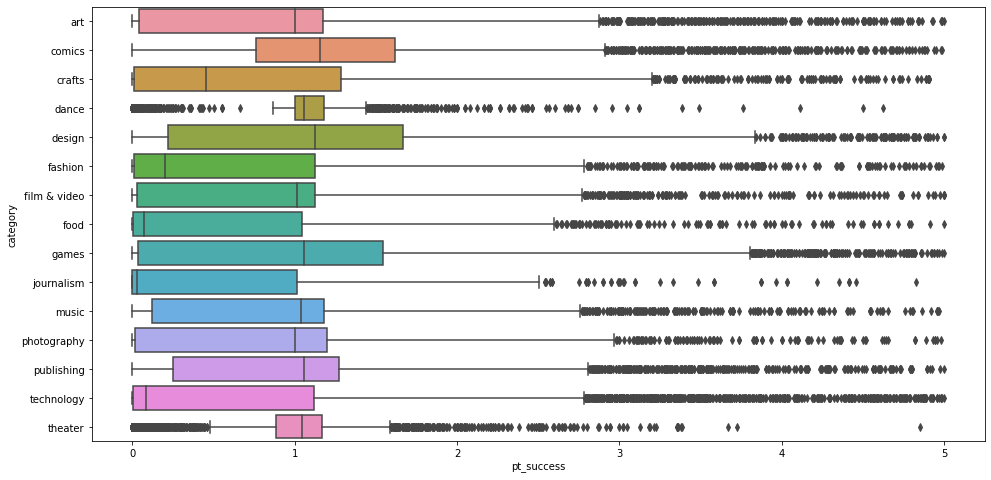

In [18]:
sns.boxplot(df_ks_to_display['pt_success'], df_ks_to_display['category'])

### **Country**

In [19]:
df_ks_to_display['country'].describe()

count     96808
unique      174
top          US
freq      74221
Name: country, dtype: object

**Top 10 countries**

In [20]:
n = 10
top_10 = df_ks_to_display['country'].value_counts()[:n].index

In [21]:
print(top_10)

Index(['US', 'GB', 'CA', 'AU', 'DE', 'FR', '?', 'NL', 'IT', 'ES'], dtype='object')


**Select top 10 countries records**

In [22]:
tops = df_ks_to_display.loc[df_ks_to_display['country'].isin(top_10)]

In [23]:
print(tops)

      project_id  backers_count  \
0      KS_000000             80   
1      KS_000001             82   
2      KS_000002             21   
3      KS_000003             37   
4      KS_000004            153   
...          ...            ...   
99995  KS_099995            104   
99996  KS_099996            307   
99997  KS_099997            143   
99998  KS_099998            329   
99999  KS_099999            145   

                                                   blurb category  \
0      I will be an artist-in-residence at Elsewhere ...      art   
1      1000 Artists is a public art-making installati...      art   
2      The Sequel to ‘My Favorite Machine”, "MyPhoneH...      art   
3      A film exploring the role and value of art edu...      art   
4      We need to build a kitchen for Habitable Space...      art   
...                                                  ...      ...   
99995  Make the workshop/ small stage space at Jimmy'...  theater   
99996  Help create a perman

**Boxplot**

<AxesSubplot:xlabel='pt_success', ylabel='country'>

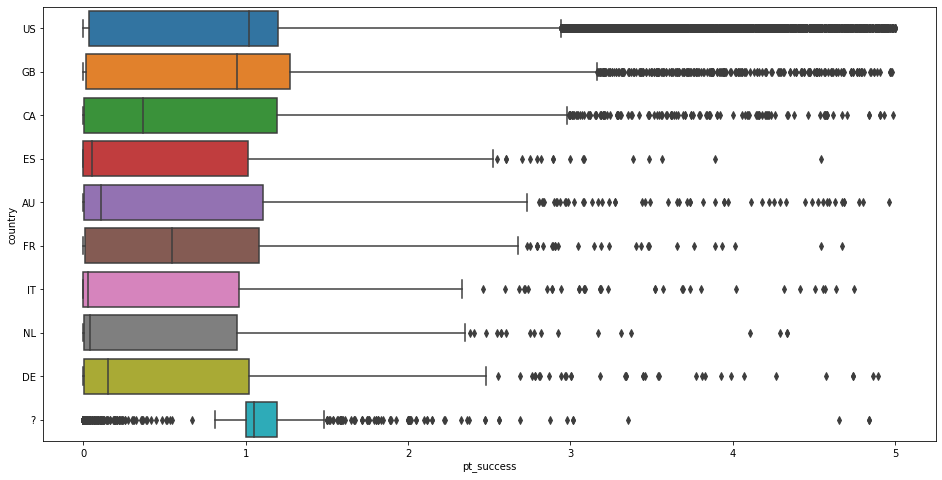

In [24]:
sns.boxplot(tops['pt_success'], tops['country'])

### **HeatMap**

**Clear invalid data**

In [25]:
hm_features = ['backers_count', 'converted_pledged_amount', 'pt_success', 'promotion_duration','usd_goal', 'staff_pick']
nulls = df_ks_to_display[hm_features].isnull().sum()
print(nulls)

backers_count               0
converted_pledged_amount    0
pt_success                  0
promotion_duration          0
usd_goal                    0
staff_pick                  0
dtype: int64


<AxesSubplot:>

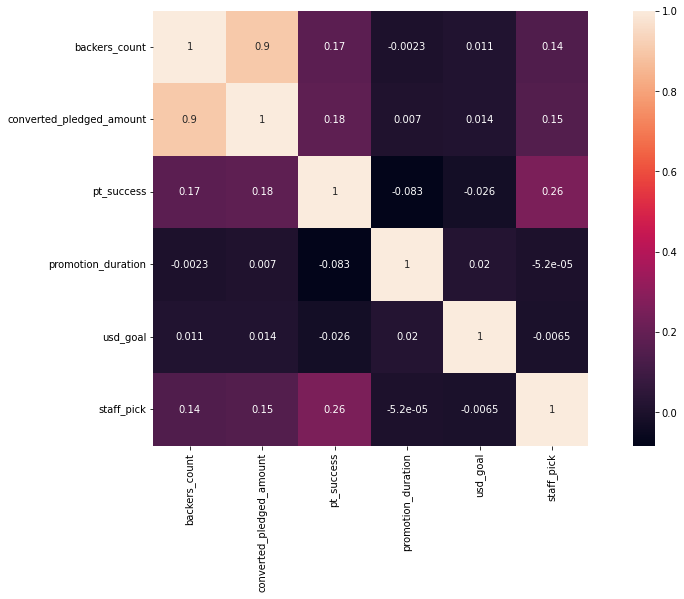

In [26]:
corrmat_all = df_ks_to_display[hm_features].corr()
sns.heatmap(corrmat_all,square=True, annot=True)

## Process Train Dataset

####  Goal convert

In [27]:
df_ks['usd_goal'] = df_ks['goal'] * df_ks['fx_rate']

In [28]:
duration = pd.to_datetime(df_ks['deadline'], unit='s') - pd.to_datetime(df_ks['launched_at'], unit='s')
df_ks['promotion_duration'] = duration / np.timedelta64(1, 'D')

## Text Feature


### **Convert Country code to numeri data**

In [59]:
from sklearn import preprocessing

#creating labelEncoder
le = preprocessing.LabelEncoder()

In [30]:
# Converting string labels into numbers.
df_ks['country_encoded'] = le.fit_transform(df_ks['country'])
print(df_ks['country_encoded'] )

0        162
1        162
2        162
3         56
4        162
        ... 
99995    162
99996    162
99997    162
99998    162
99999     56
Name: country_encoded, Length: 100000, dtype: int32


### **Convert Category code to numeri data**

In [60]:
df_ks['category_encoded'] = le.fit_transform(df_ks['category'])
#print(df_ks['category_encoded'])

### Convert Staff Pick to numerical data

In [32]:
#df_ks['sf_encoded'] = le.fit_transform(df_ks['staff_pick'])

## Blurb & Name Process

### **Convert Blurb into TF-IDF matrix**

Test using TF-IDF to convert text feature into numerical features.

Print blurb information

In [33]:
print(df_ks.blurb[15])
print(df_ks.funded[15])

The Boston Cod Piece is a giant Codfish on the Circle of Regional Effigies (CORE) at Burning Man 2012. (Structure and Framing Funds)
True


Convert `funded` into `0` and `1`

**转化之后反而没有办法来fit model了！！！**

In [34]:

# data_ks_prep.loc[data_ks_prep.funded == True, 'funded'] = 1
# data_ks_prep.loc[data_ks_prep.funded == False, 'funded'] = 0

In [35]:
print('invalid funded entries:', df_ks.funded.isnull().sum())

invalid funded entries: 0


**Test if funded are converted**

In [36]:
#print(data_ks_prep.funded[15])

### 预处理Blurb


**用空格替换NaN数据**

In [37]:
#好像不起作用

# data_ks_prep.loc[data_ks_prep.blurb.isnull(), 'funded'] = ' '
# print('invalid Blurb entries:', data_ks_prep.blurb.isnull().sum())
# print(data_ks_prep.loc[data_ks_prep['blurb'].isnull()])

### 对文本进行分词
构建特征字典，将文档转换成特征向量

In [38]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data_ks_prep.blurb.values.astype('U'))
X_train_counts.shape

NameError: name 'data_ks_prep' is not defined

**构建N-gram模型字典**

In [ ]:
count_vect.vocabulary_.get(u'algorithm')

**根据词频算法重构**

In [ ]:
tf_vec = TfidfVectorizer()
X_train_tf = tf_vec.fit_transform(df_ks.blurb.values.astype('U'))
X_train_tf.shape

In [ ]:

# blurbs = data_ks_train['blurb']
# vec = TfidfVectorizer()
# X = vec.fit_transform(blurbs.values.astype('U'))
# pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

#names = data_ks_train['name']
#vec = TfidfVectorizer()
#X2 = vec.fit_transform(names.values.astype('U'))
#pd.DataFrame(X2.toarray(), columns=vec.get_feature_names())


## 拆分为Train Dataset 和 Test Dataset

In [66]:
#TF-IDF vectorize -> NB -> blurb_factor
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

tf_vec = TfidfVectorizer()
ct_vec = CountVectorizer()

text = df_ks.blurb.values.astype('U')

target = df_ks["funded"]


train_text = tf_vec.fit(text, target)
train_text2 = ct_vec.fit(text, target)

vec = train_text.transform(text)
vec2 = train_text2.transform(text)

NB = MultinomialNB()
NB.fit(vec, target)


df_ks['blurb_factor'] = NB.predict(vec)
vec.shape

(100000, 73043)

In [67]:
#TF-IDF vectorize -> NB -> name_factor
text = df_ks.name.values.astype('U')
train_text = tf_vec.fit(text, target)
vec = train_text.transform(text)
NB.fit(vec, target)
df_ks['name_factor'] = NB.predict(vec)

In [68]:
#Determine features and split test sets
features = ['blurb_factor', 'name_factor', 'staff_pick']
# features = ['category_encoded']

X = df_ks[features]
y = df_ks['funded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [69]:
#Logistic regression
from sklearn.svm import LinearSVC

lr = LinearSVC()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)


0.8077

In [70]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)
# knn.score(X_train, y_train)
# knn.score(X_test, y_test)

from sklearn import metrics
pre_y = knn.predict(X_test)
metrics.accuracy_score(y_test, pre_y)

0.8077

In [51]:
#Random forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8)
bag.fit(X_train, y_train)
bag.score(X_test, y_test)

0.8089

In [52]:
#Deep learning
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs')
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

0.8089

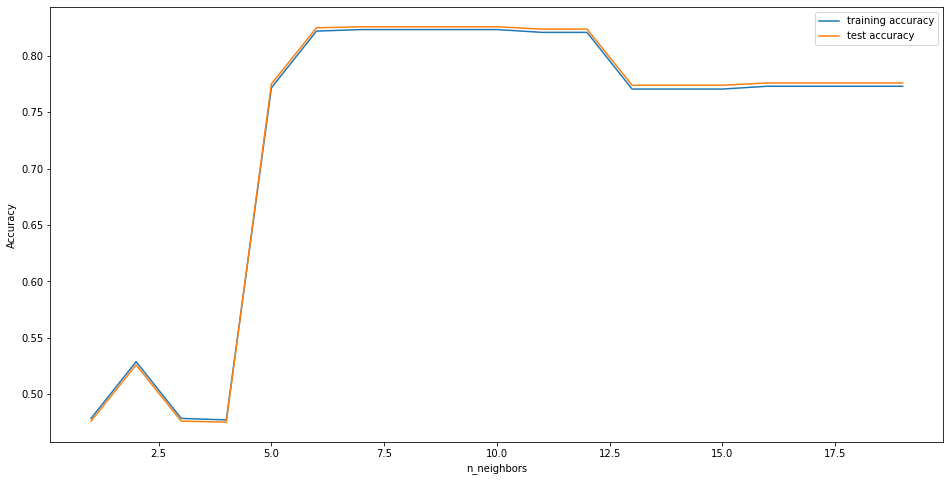

In [135]:
#KNN optimal performance visualization
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 20)
for n_neighbors in neighbors_settings:
 # build the model
 clf = KNeighborsClassifier(n_neighbors=n_neighbors)
 clf.fit(X_train, y_train)
 # record training set accuracy
 training_accuracy.append(clf.score(X_train, y_train))
 # record generalization accuracy
 test_accuracy.append(clf.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [57]:
features = ['usd_goal','promotion_duration','country_encoded','category_encoded','staff_pick']

# 尝试直接使用Country和Category，但是KNN不能fit这种feature
#features = ['usd_goal','promotion_duration','country','category','staff_pick']
#features = ['usd_goal','promotion_duration']
X = df_ks[features]
y = df_ks['funded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

KeyError: "['usd_goal', 'promotion_duration', 'country_encoded', 'category_encoded'] not in index"

### 测试 to_display dataset 的train Score

In [ ]:
df_ks_to_display['country_encoded'] = le.fit_transform(df_ks_to_display['country'])
df_ks_to_display['category_encoded'] = le.fit_transform(df_ks_to_display['category'])
#df_ks_to_display['staffpick_encoded'] = le.fit_transform(df_ks_to_display['category'])


In [ ]:
features_dis = ['usd_goal','promotion_duration','country_encoded','category_encoded']
X = df_ks_to_display[features_dis]
y = df_ks_to_display['funded']

X_train_dis, X_test_dis, y_train_dis, y_test_dis = train_test_split(X, y, test_size = 0.3)

## 尝试使用贝叶斯来分类

前期准备

In [ ]:
train_blurb = tf_vec.fit_transform(df_ks.blurb.values.astype('U'))
test_blurb = tf_vec.fit_transform(df_ks.blurb.values.astype('U'))

In [ ]:
usd_goal = X_train['usd_goal']
promotion_duration = X_train['promotion_duration']
country_encoded = X_train['country_encoded']
category_encoded = X_train['category_encoded']

nb_train_features=list(zip(usd_goal,promotion_duration,country_encoded,category_encoded))

In [ ]:
t_usd_goal = X_test['usd_goal']
t_promotion_duration = X_test['promotion_duration']
t_country_encoded = X_test['country_encoded']
t_category_encoded = X_test['category_encoded']

nb_test_features=list(zip(usd_goal,promotion_duration,country_encoded,category_encoded))

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(nb_train_features,y_train)



In [ ]:
clf.score(nb_train_features, y_train)

0.6343

In [ ]:
y_pred = clf.predict(X_test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 5)

In [ ]:
clf.score(nb_test_features, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [30000, 70000]

## KNN Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=500)

knn.fit(X_train_dis, y_train_dis)

NameError: name 'X_train_dis' is not defined

### Predict test target

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8071


## Evaluate

### **R Score**

#### **Kth-Neighbour R score comparision Graph**

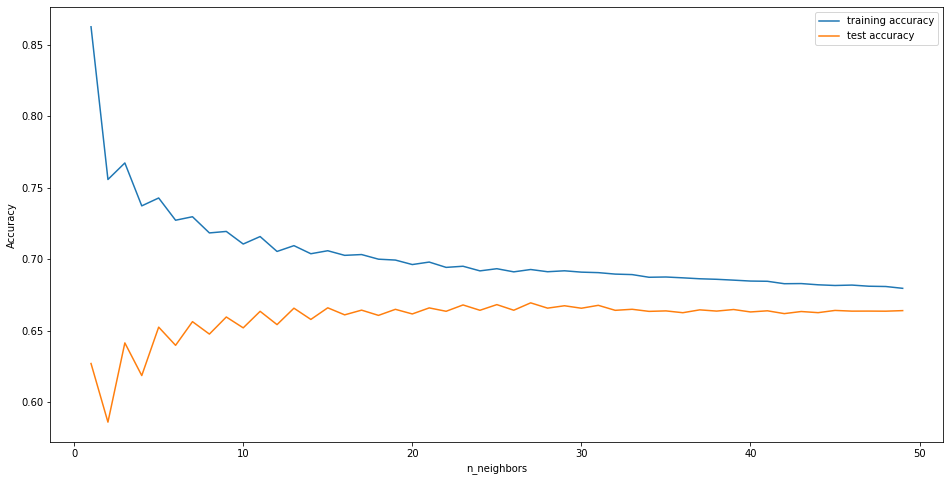

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 50)
for n_neighbors in neighbors_settings:
 # build the model
 clf = KNeighborsClassifier(n_neighbors=n_neighbors)
 clf.fit(X_train, y_train)
 # record training set accuracy
 training_accuracy.append(clf.score(X_train, y_train))
 # record generalization accuracy
 test_accuracy.append(clf.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 50)
for n_neighbors in neighbors_settings:
 # build the model
 clf = KNeighborsClassifier(n_neighbors=n_neighbors)
 clf.fit(X_train_dis, y_train_dis)
 # record training set accuracy
 training_accuracy.append(clf.score(X_train_dis, y_train_dis))
 # record generalization accuracy
 test_accuracy.append(clf.score(X_test_dis, y_test_dis))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [ ]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))